In [1]:
import autograd
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys

import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib

import bnpmodeling_runjingdev.modeling_lib as modeling_lib 
import bnpmodeling_runjingdev.cluster_quantities_lib as cluster_lib
import bnpmodeling_runjingdev.optimization_lib as optimization_lib


import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles

import time 

import json 

import scipy as osp

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Load data

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

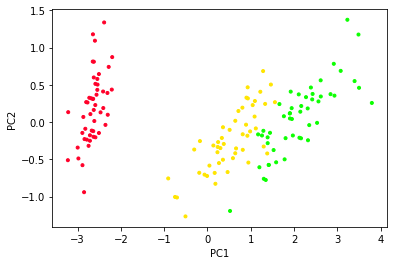

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Get prior

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)
prior_params_dict['alpha'] = np.array([3.0])
print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


# Get VB params 

In [6]:
k_approx = 30

In [7]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

In [8]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [9]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

1459.0115663552124

## Initialize 

In [10]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6580.095037059639


In [11]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

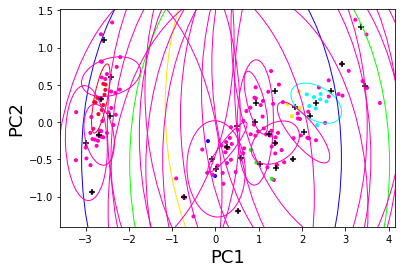

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, init_vb_params_dict, init_ez, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Run CAVI

In [13]:
vb_opt_dict, e_z_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False)

done. num iterations = 266
stick_time: 1.52sec
cluster_time: 0.144sec
e_z_time: 0.382sec
**TOTAL time: 4.607sec**


In [14]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

# Define objective

In [15]:
# get loss as a function of vb parameters
get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = [vb_params_paragami, prior_params_paragami],
                                free = True,
                                argnums = [1, 2])

objective_fun = lambda x, y : get_vb_params_loss(features, x, y, gh_loc, gh_weights)


In [16]:
# get derivative functions
obj_fun_grad = autograd.grad(objective_fun, argnum=0)
obj_fun_hessian = autograd.hessian(objective_fun, argnum=0)
obj_fun_hvp = autograd.hessian_vector_product(
            objective_fun, argnum=0)

# Derivative times

In [17]:
t0 = time.time()
loss = objective_fun(vb_opt, prior_params_free)
print('function time: {:0.3}sec'.format(time.time() - t0))

function time: 0.00919sec


In [18]:
t0 = time.time()
grad = obj_fun_grad(vb_opt, prior_params_free)
print('gradient time: {:0.3}sec'.format(time.time() - t0))

gradient time: 0.059sec


In [19]:
# if its impossible, don't run the hessian
run_hessian = True

In [20]:
if run_hessian: 
    t0 = time.time()
    hess = obj_fun_hessian(vb_opt, prior_params_free)
    print('hessian time: {:0.3}sec'.format(time.time() - t0))

hessian time: 14.0sec


In [21]:
t0 = time.time()

x = np.zeros(len(vb_opt))# vb_opt
x[0] = 1
hvp = obj_fun_hvp(vb_opt, prior_params_free, x)
print('hvp time: {:0.3}sec'.format(time.time() - t0))

hvp time: 0.115sec


In [22]:
# cross hessian 
hyper_obj_fun_grad = \
            autograd.grad(objective_fun, argnum=0)
hyper_obj_cross_hess = autograd.jacobian(hyper_obj_fun_grad, argnum=1)

In [23]:
t0 = time.time()
cross_hess = hyper_obj_cross_hess(vb_opt, prior_params_free)
print('cross-hessian time: {:0.3}sec'.format(time.time() - t0))

cross-hessian time: 4.34sec


# Solver times

In [24]:
if run_hessian: 
    chol_solver = vittles.solver_lib.get_cholesky_solver(hess)
    
    t0 = time.time()
    dinput_dhyper = -chol_solver(cross_hess)
    
    print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 0.00151sec


In [25]:
cg_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt))
    
t0 = time.time()
dinput_dhyper2 = -cg_solver(cross_hess[:, 0])
    
print('solver time: {:0.3}sec'.format(time.time() - t0))

solver time: 9.15sec


In [26]:
mfvb_preconditioner = preconditioner_lib.get_gmm_preconditioner(vb_opt, vb_params_paragami)

In [27]:
cg_solver_mfvb_precond = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_opt, prior_params_free, x), 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner})
    
t0 = time.time()
dinput_dhyper3 = -cg_solver_mfvb_precond(cross_hess[:, 0])
    
print('preconditioned solver time: {:0.3}sec'.format(time.time() - t0))

preconditioned solver time: 4.92sec


# Lets look at the CG solver in more detail 

### Check out eigenvalues

In [28]:
hess_ev = np.linalg.eigvals(hess)

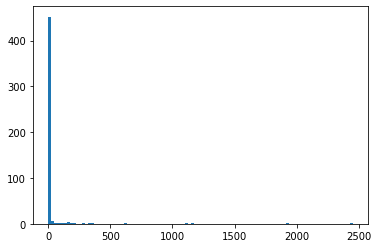

In [29]:
plt.hist(hess_ev - hess_ev.min(), bins = 100);

In [30]:
precond_sqrt = osp.linalg.sqrtm(mfvb_preconditioner.toarray())
np.abs(precond_sqrt - precond_sqrt.transpose()).max()

3.567538391042636e-14

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/lib/histograms.py:854: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/matplotlib/transforms.py:1959: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


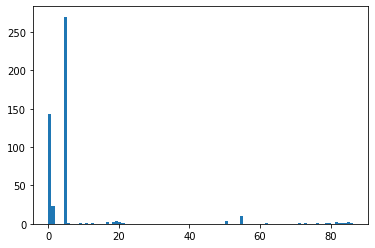

In [31]:
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
precon_hess_ev = np.linalg.eigvals(precond_hess)
plt.hist(precon_hess_ev - precon_hess_ev.min(), bins = 100);

In [32]:
dim = len(vb_opt)
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
linop = osp.sparse.linalg.LinearOperator((dim, dim), mat_times_vec)

b = cross_hess[:, 0]

### Check out optimization path

In [33]:
class CGCallback(): 
    def __init__(self, mat_times_vec, b): 
        self.mat_times_vec = mat_times_vec
        self.b = b
        
        self.residuals = []
        
    def record_residuals(self, x): 
#         e_z = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
#                                        vb_params_paragami.fold(x, free = True), 
#                                        gh_loc, gh_weights)
        
#         e_num_clust = cluster_lib.get_e_num_clusters_from_ez(e_z)
        
#         self.residuals.append(e_num_clust)
        
#         self.residuals.append(np.linalg.norm(b - self.mat_times_vec(x)))

        self.residuals.append(np.linalg.norm(-x - dinput_dhyper[:, 0]))
        
    def return_path(self): 
        return np.array(self.residuals)

In [34]:
mat_times_vec = lambda x : obj_fun_hvp(vb_opt, prior_params_free, x)
b = cross_hess[:, 0]
cg_callback = CGCallback(mat_times_vec, b)

x0 = mfvb_preconditioner.dot(b)

In [35]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path1 = cg_callback.return_path()

solver time: 9.63sec


In [36]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':mfvb_preconditioner, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path2 = cg_callback.return_path()

solver time: 4.73sec


Text(0, 0.5, 'log10 residual')

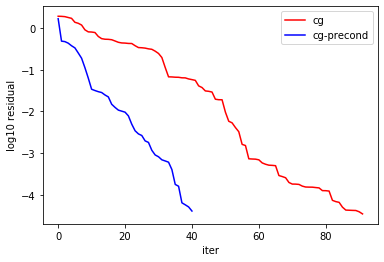

In [37]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond')
plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Try nystrom

In [38]:
def taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter):
    
    t_power = deepcopy(v)
    x_inv_v = deepcopy(v)
    
    for i in range(max_iter): 
        t_power = t_power - mat_vec(t_power) / (max_eval + 1)
        x_inv_v += t_power
    
    return x_inv_v / (max_eval + 1)

In [39]:
# a quick test 
dim = 3
_a = np.random.randn(dim, dim)
a = np.dot(_a, _a.transpose())

mat_vec = lambda x: np.dot(a, x)

max_eval = np.linalg.eigvals(a).max()

v = np.random.randn(dim)

foo = taylor_expand_matrix_inverse(mat_vec, v, max_eval, max_iter = 1000)

true = np.linalg.solve(a, v)

print(foo / true)

[0.99998116 0.99998158 0.99998168]


In [40]:
def get_nystrom_woodbury_approx(A, indx): 
    C = A[:, indx]
    W_inv = np.linalg.inv(A[indx][:, indx])
    
    inv_term = np.linalg.inv(np.eye(C.shape[1]) - np.dot(W_inv, np.dot(C.transpose(), C)))
    
    woodb_inv = np.eye(C.shape[0]) + np.dot(np.dot(C, inv_term), np.dot(W_inv, C.transpose()))
    
    return woodb_inv, C, W_inv

In [41]:
# another quick test 
a = np.random.randn(3, 3)
A = np.eye(3) + np.dot(a, a.transpose())

woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx = np.array([0, 1]))

A_tilde = np.dot(np.dot(C, W_inv), C.transpose())

np.abs(np.linalg.inv(np.eye(3) - A_tilde) - woodb_inv).max()

4.440892098500626e-16

## Get large clusters

In [42]:
e_z_opt = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                       vb_params_paragami.fold(vb_opt, free = True), 
                                       gh_loc, gh_weights)

In [43]:
k_large = 5
which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

In [44]:
which_k

array([2, 4, 0, 1, 3])

In [45]:
import bnpmodeling_runjingdev.modeling_lib as modeling_lib
log_probs = modeling_lib.get_e_log_cluster_probabilities(vb_params_dict['stick_params']['stick_propn_mean'],
                                            vb_params_dict['stick_params']['stick_propn_info'], 
                                            gh_loc, gh_weights)
np.argsort(-log_probs)[0:k_large]

array([2, 4, 0, 1, 3])

In [46]:
bool_dict = vb_params_paragami.empty_bool(False)
bool_dict['cluster_params']['centroids'][:, which_k] = True
bool_dict['cluster_params']['cluster_info'][which_k] = True

_which_k = which_k
_which_k = _which_k[_which_k != (k_approx - 1)]
bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
bool_dict['stick_params']['stick_propn_info'][_which_k] = True

In [47]:
indx = vb_params_paragami.flat_indices(bool_dict, free = True)

In [48]:
len(indx)

80

In [49]:
est_lambda_max = np.max(np.linalg.eigvals(hess)) 
# est_lambda_max = np.abs(hess).sum(0).max() * 100.

A = np.eye(hess.shape[0]) - hess / est_lambda_max

In [50]:
print('est lambda_max: ', est_lambda_max)
print('true lambda_max: ', np.max(np.linalg.eigvals(hess)))

est lambda_max:  2451.1259105527097
true lambda_max:  2451.1259105527097


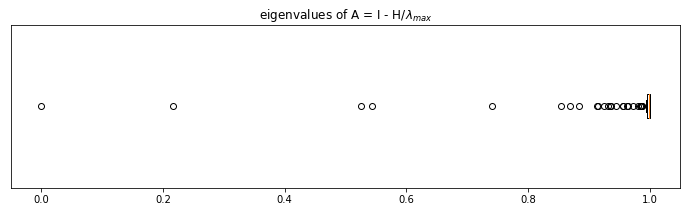

In [51]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(np.linalg.eigvals(A), vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of A = I - H/$\lambda_{max}$'); 

In [52]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A, indx)
nystrom_precond = woodb_inv/est_lambda_max

/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


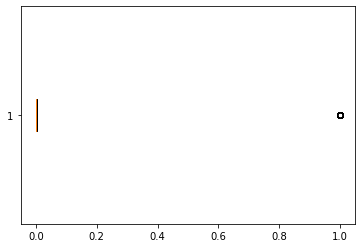

In [53]:
woodb_inv_sqrt = osp.linalg.sqrtm(woodb_inv)
m = np.dot(woodb_inv_sqrt, np.dot(np.eye(len(A)) - A, woodb_inv_sqrt))
plt.boxplot(np.linalg.eigvals(m), vert=False);
# plt.hist(np.linalg.eigvals(m))

In [54]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

(1.0000007367698922-1.377410568111461e-17j)
(7523.440067052681-1.733777059761098e-12j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


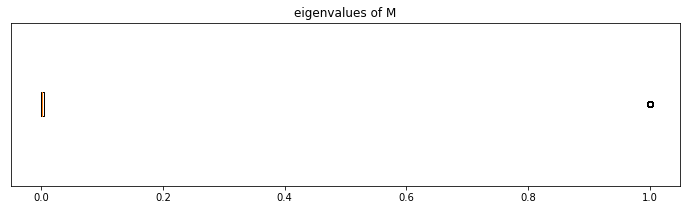

In [55]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [56]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path3 = cg_callback.return_path()

solver time: 3.64sec


Text(0, 0.5, 'log10 residual')

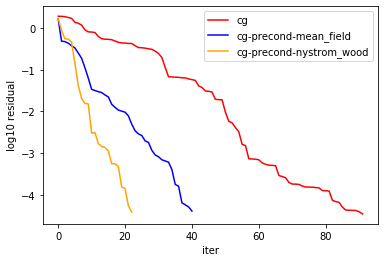

In [57]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Crazy idea ... use only one block

In [58]:
bin_mat1 = np.zeros(hess.shape)
bin_mat1[indx] = 1.0

bin_mat2 = np.zeros(hess.shape)
bin_mat2[:, indx] = 1.0

bin_mat = bin_mat1 * bin_mat2

In [59]:
assert np.all(bin_mat[indx][:, indx] == 1)
assert np.all(bin_mat * (1 - bin_mat) == 0)

In [60]:
# set some blocks to zero
A2 = np.eye(hess.shape[0]) - hess * bin_mat / est_lambda_max

In [61]:
(hess - hess * bin_mat).max()

10.142413366623114

In [62]:
(hess - hess * (1 - bin_mat)).max()

1725.7477546185044

In [63]:
(A - A2).max()

0.0002355968833660157

In [64]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A2, indx)
nystrom_precond2 = woodb_inv/est_lambda_max

In [65]:
np.abs(nystrom_precond2 - nystrom_precond).max()

0.07432392550546005

In [66]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond2)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.min())
print(evals.max())

(0.00013289791134470083+0j)
(1.0000195307597624+0j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


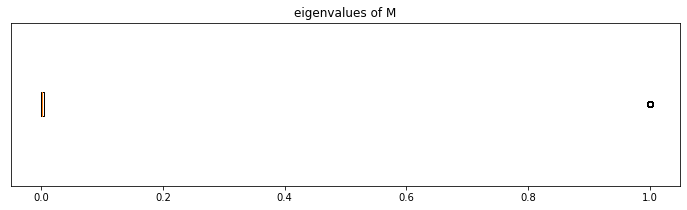

In [67]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [68]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond2, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path4 = cg_callback.return_path()

solver time: 3.67sec


Text(0, 0.5, 'log10 residual')

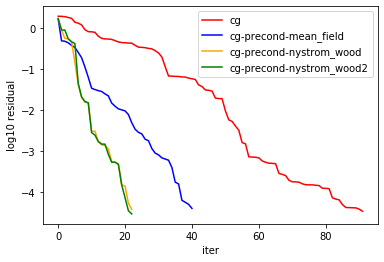

In [69]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')

# Can we try to estimate that upper block?

In [70]:
from bnpgmm_runjingdev.gmm_clustering_lib import get_optimal_z_from_vb_params_dict, get_z_nat_params

In [71]:
# break down the components of the Hessian 
kl_objective = lambda x, y : gmm_lib.get_kl(features, x, prior_params_dict, 
                                            gh_loc, gh_weights, e_z = y, 
                                            use_bnp_prior=use_bnp_prior)

In [72]:
def get_kl_from_ez_nat(vb_params_dict, z_nat_param): 
    e_z = convert_nat_param_to_ez(z_nat_param)
    return kl_objective(vb_params_dict, e_z)

In [73]:
def convert_nat_param_to_ez(z_nat_param): 
    log_const = sp.special.logsumexp(z_nat_param, axis=1)
    return np.exp(z_nat_param - log_const[:, None])

In [74]:
def get_ez_nat(y, vb_params_dict, use_bnp_prior): 
    stick_propn_mean = vb_params_dict['stick_params']['stick_propn_mean']
    stick_propn_info = vb_params_dict['stick_params']['stick_propn_info']
    centroids = vb_params_dict['cluster_params']['centroids']
    cluster_info = vb_params_dict['cluster_params']['cluster_info']

    return get_z_nat_params(y, stick_propn_mean, stick_propn_info, centroids, cluster_info,
                        gh_loc, gh_weights,
                        use_bnp_prior = use_bnp_prior)[0]

In [75]:
use_bnp_prior = True

In [110]:
def get_hessian_components(vb_params_dict, vb_params_paragami): 
    vb_opt = vb_params_paragami.flatten(vb_params_dict, free = True)
    
    e_z_opt = get_optimal_z_from_vb_params_dict(features, vb_params_dict, 
                                                gh_loc, gh_weights, 
                                                use_bnp_prior=use_bnp_prior)
    e_z_nat = get_ez_nat(features, vb_params_dict, use_bnp_prior)
    
    
    # kl_theta_theta
    get_kl_flat = paragami.FlattenFunctionInput(
                                original_fun=kl_objective, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 0)


    get_kl_thetatheta = autograd.hessian(get_kl_flat, argnum = 0)
    t0 = time.time()
    kl_thetatheta = get_kl_thetatheta(vb_opt, e_z_opt)
    print('kl_thetatheta time: ', time.time() - t0)
    
    # e_z_theta
    get_ez_nat_flat = paragami.FlattenFunctionInput(
                                original_fun=get_ez_nat, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

    get_ez_grad = autograd.jacobian(lambda x : get_ez_nat_flat(features, x, 
                                                                use_bnp_prior = use_bnp_prior))

    t0 = time.time()
    ez_grad = get_ez_grad(vb_opt)
    print('ez_grad time: ', time.time() - t0)
    
    get_kl_flat_from_ez = paragami.FlattenFunctionInput(
                                original_fun=get_kl_from_ez_nat, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 0)
    
    t0 = time.time()
    get_kl_theta = autograd.grad(get_kl_flat_from_ez, argnum = 0)
    get_kl_thetaez = autograd.jacobian(get_kl_theta, argnum = 1)

    kl_thetaez  = get_kl_thetaez(vb_opt, e_z_nat)
    print('kl_thetaez time: ', time.time() - t0)
    
    return kl_thetatheta, ez_grad, kl_thetaez

In [ ]:
vb_params_dict = vb_params_paragami.fold(vb_opt, free = True)
kl_thetatheta, ez_grad, kl_thetaez = \
    get_hessian_components(vb_params_dict, vb_params_paragami)

kl_thetatheta time:  7.872802495956421


In [ ]:
est = np.einsum('ijk, jkl -> il', kl_thetaez, ez_grad) + kl_thetatheta

In [ ]:
np.abs(est - hess).max()

In [71]:
bool_dict = vb_params_paragami.empty_bool(False)
bool_dict['cluster_params']['centroids'][:, which_k] = True
bool_dict['cluster_params']['cluster_info'][which_k] = True

_which_k = which_k[:-1]
_which_k = _which_k[_which_k != (k_approx - 1)]
bool_dict['stick_params']['stick_propn_mean'][_which_k] = True
bool_dict['stick_params']['stick_propn_info'][_which_k] = True

In [72]:
indx2 = vb_params_paragami.flat_indices(bool_dict, free = True)

In [73]:
def convert_nat_param_to_ez(z_nat_param): 
    log_const = sp.special.logsumexp(z_nat_param, axis=1)
    return np.exp(z_nat_param - log_const[:, None])

In [74]:
def get_ez_nat(y, vb_params_dict, use_bnp_prior): 
    stick_propn_mean = vb_params_dict['stick_params']['stick_propn_mean']
    stick_propn_info = vb_params_dict['stick_params']['stick_propn_info']
    centroids = vb_params_dict['cluster_params']['centroids']
    cluster_info = vb_params_dict['cluster_params']['cluster_info']

    return get_z_nat_params(y, stick_propn_mean, stick_propn_info, centroids, cluster_info,
                        gh_loc, gh_weights,
                        use_bnp_prior = use_bnp_prior)[0]

In [82]:
def get_subhess_estimate(): 
    
    use_bnp_prior = True

    # get original vb parameters 
    vb_params_dict = vb_params_paragami.fold(vb_opt, free = True)
    
    # get e_z
    e_z_opt = get_optimal_z_from_vb_params_dict(features, vb_params_dict, 
                                                gh_loc, gh_weights, 
                                                use_bnp_prior=use_bnp_prior)
    
#     k_approx = vb_params_dict['cluster_params']['centroids'].shape[1]
    
#     # get vb parameters for the sub-problem
#     sub_vb_params_dict, sub_vb_params_paragami = \
#         gmm_lib.get_vb_params_paragami_object(features.shape[1], len(which_k))
    
#     which_k_sorted = np.sort(which_k)
#     _which_k = which_k[:-1]
#     _which_k_sorted = np.sort(_which_k)
    
#     sub_vb_params_dict['cluster_params']['centroids'] = \
#         vb_params_dict['cluster_params']['centroids'][:, which_k_sorted]
#     sub_vb_params_dict['cluster_params']['cluster_info'] = \
#         vb_params_dict['cluster_params']['cluster_info'][which_k_sorted]

#     sub_vb_params_dict['stick_params']['stick_propn_mean'] = \
#         vb_params_dict['stick_params']['stick_propn_mean'][_which_k_sorted]
#     sub_vb_params_dict['stick_params']['stick_propn_info'] = \
#         vb_params_dict['stick_params']['stick_propn_info'][_which_k_sorted]

#     sub_vb_params_free = sub_vb_params_paragami.flatten(sub_vb_params_dict, free = True)
    
    sub_vb_params_paragami = vb_params_paragami
    sub_vb_params_free = vb_opt
    
    # break down the components of the Hessian 
    kl_objective = lambda x, y : gmm_lib.get_kl(features, x, prior_params_dict, 
                                                gh_loc, gh_weights, e_z = y, 
                                                use_bnp_prior=use_bnp_prior)
    
    # the e_z on the subproblem 
#     _sub_e_z_opt = e_z_opt[:, which_k_sorted]
    _sub_e_z_opt = e_z_opt
    
    # kl_theta_theta
    sub_get_kl_flat = paragami.FlattenFunctionInput(
                                original_fun=kl_objective, 
                                patterns = sub_vb_params_paragami,
                                free = True,
                                argnums = 0)


    get_sub_kl_thetatheta = autograd.hessian(sub_get_kl_flat, argnum = 0)
    t0 = time.time()
    sub_kl_thetatheta = get_sub_kl_thetatheta(sub_vb_params_free, _sub_e_z_opt)
    print('sub_kl_thetatheta time: ', time.time() - t0)
    
    # e_z_theta
    get_sub_ez_nat_flat = paragami.FlattenFunctionInput(
                                original_fun=get_ez_nat, 
                                patterns = sub_vb_params_paragami,
                                free = True,
                                argnums = 1)

    t0 = time.time()
    get_sub_ez_grad = autograd.jacobian(lambda x : get_sub_ez_nat_flat(features, x, 
                                                                        use_bnp_prior = use_bnp_prior))
    sub_ez_grad = get_sub_ez_grad(sub_vb_params_free)
    print('sub_ez_grad time: ', time.time() - t0)
    
    # grad kl_ez_theta
    def get_kl_from_ez_nat(vb_params_dict, z_nat_param): 
        e_z = convert_nat_param_to_ez(z_nat_param)
        return kl_objective(vb_params_dict, e_z)
    
    get_kl_flat_from_ez = paragami.FlattenFunctionInput(
                                original_fun=get_kl_from_ez_nat, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 0)

    t0 = time.time()
    get_kl_theta = autograd.grad(get_kl_flat_from_ez, argnum = 0)
    get_kl_thetaez = autograd.jacobian(get_kl_theta, argnum = 1)
    
    e_z_nat = get_ez_nat(features, vb_params_dict, use_bnp_prior)
    kl_thetaez  = get_kl_thetaez(vb_opt, e_z_nat)
    print('kl_thetaez time: ', time.time() - t0)
    
    # construct estimates
#     _kl_thetatheta = np.zeros((len(vb_opt), len(vb_opt)))
#     for i in range(len(sub_kl_thetatheta)): 
#         for j in range(len(sub_kl_thetatheta)): 
#             _kl_thetatheta[indx2[i], indx2[j]] = sub_kl_thetatheta[i, j]

#     assert (_kl_thetatheta[indx2][:, indx2] == sub_kl_thetatheta).all()

#     _ez_grad = np.zeros((e_z_opt.shape[0], e_z_opt.shape[1], len(vb_opt)))
#     for i in range(len(which_k_sorted)): 
#         _ez_grad[:, which_k_sorted[i], indx2] = sub_ez_grad[:, i, :]

#     assert np.all(sub_ez_grad == _ez_grad[:, which_k_sorted, :][:, :, indx2])
    
    _ez_grad = sub_ez_grad
    _kl_thetatheta = sub_kl_thetatheta
    est = np.einsum('ijk, jkl -> il', kl_thetaez, _ez_grad) + _kl_thetatheta
    
    return est

In [83]:
hess2 = get_subhess_estimate() 

sub_kl_thetatheta time:  7.003047466278076
sub_ez_grad time:  49.43728518486023
kl_thetaez time:  3.9601149559020996


In [84]:
A3 = np.eye(hess.shape[0]) - hess2 / est_lambda_max

In [85]:
# get woodbury-nystrom preconditioner
woodb_inv, C, W_inv = get_nystrom_woodbury_approx(A3, indx2)
nystrom_precond3 = woodb_inv/est_lambda_max

In [86]:
nystrom_precond3

array([[ 5.55129836e-02, -4.54020481e-05,  8.28266845e-04, ...,
        -1.05704571e-10, -8.14195196e-11, -6.40325096e-11],
       [-4.54020480e-05,  1.89566347e-01, -4.22665278e-04, ...,
         3.80931477e-11,  2.93414564e-11,  2.30756383e-11],
       [ 8.28266838e-04, -4.22665277e-04,  3.96548627e-03, ...,
         3.20610562e-10,  2.46952328e-10,  1.94216468e-10],
       ...,
       [-1.05781735e-10,  3.81100069e-11,  3.20400606e-10, ...,
         4.07975783e-04,  3.79440859e-12,  2.98410875e-12],
       [-8.14789554e-11,  2.93544422e-11,  2.46790609e-10, ...,
         3.79440859e-12,  4.07975781e-04,  2.29852163e-12],
       [-6.40792528e-11,  2.30858510e-11,  1.94089284e-10, ...,
         2.98410875e-12,  2.29852163e-12,  4.07975780e-04]])

In [87]:
nystrom_precond2

array([[ 5.55130326e-02, -4.54322956e-05,  8.28005448e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.54322948e-05,  1.89566371e-01, -4.22501016e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 8.28005441e-04, -4.22501016e-04,  3.96690516e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.07975778e-04,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  4.07975778e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  4.07975778e-04]])

In [88]:
precond_sqrt = osp.linalg.sqrtm(nystrom_precond3)
precond_hess = np.dot(precond_sqrt, np.dot(hess, precond_sqrt))
evals = np.linalg.eigvals(precond_hess)
print(evals.max())
print(evals.max() / evals.min())

(1.0000008816547834+7.23910139656509e-24j)
(7614.166980149702-4.131347431236187e-14j)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


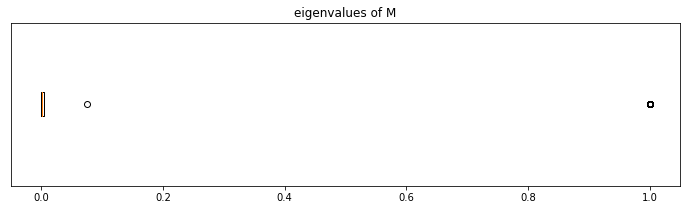

In [89]:
f, axarr = plt.subplots(1, 1, figsize=(12, 3))
axarr.boxplot(evals, vert=False);
axarr.set_yticks([]);
axarr.set_title('eigenvalues of M'); 

In [90]:
cg_callback = CGCallback(mat_times_vec, b)
solver = vittles.solver_lib.get_cg_solver(mat_times_vec, 
                                            dim = len(vb_opt), 
                                            cg_opts={'M':nystrom_precond3, 
                                                     'callback':cg_callback.record_residuals, 
                                                    'x0':x0})
    
t0 = time.time()
_ = -solver(b)
print('solver time: {:0.3}sec'.format(time.time() - t0))
path5 = cg_callback.return_path()

solver time: 5.1sec


Text(0, 0.5, 'log10 residual')

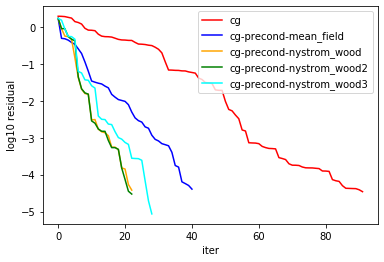

In [91]:
plt.plot(np.log10(path1), color = 'red', label = 'cg')
plt.plot(np.log10(path2), color = 'blue', label = 'cg-precond-mean_field')
plt.plot(np.log10(path3), color = 'orange', label = 'cg-precond-nystrom_wood')
plt.plot(np.log10(path4), color = 'green', label = 'cg-precond-nystrom_wood2')
plt.plot(np.log10(path5), color = 'cyan', label = 'cg-precond-nystrom_wood3')

plt.legend()

plt.xlabel('iter')
plt.ylabel('log10 residual')